In [75]:
import os
import re
import json
import bisect
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
DATA_DIR_RAW = '/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/2010_relations_challenge'
DATA_DIR = r'/Users/chenkx/Box Sync/NLP group/2010 i2b2 challenge - rel'
MAP_DIR = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/notebooks/2010Corpus/Section_mapping_v2_test.csv"

In [35]:
with open(MAP_DIR, 'r') as f:
    section_map = f.read()
section_map = section_map.split('\n')[1:]
section_map = {i.split(',')[0]:i.split(',')[1] for i in section_map}

In [7]:
MAP_DIR1 = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/simple_header_map.json"
MAP_DIR2 = "/Users/chenkx/Desktop/TBIC-not_synced/Sectionizer/data/section_mapping/sectionTypeMapping.json"
with open(MAP_DIR1, 'r') as f:
    section_map1 = json.load(f)
with open(MAP_DIR2, 'r') as f:
    section_map2_tmp = json.load(f)
section_map2 = {}
# reformat section_map2 to lower case
for i in section_map2_tmp:
    section_map2[i.lower()] = section_map2_tmp[i].lower()
del section_map2_tmp

In [8]:
len(section_map)

802

In [9]:
filenames = [i[:-4] for i in os.listdir(os.path.join(\
    DATA_DIR, "test", "txt")) \
     if i.endswith(".txt")]

In [11]:
file = filenames[0]

In [12]:
with open(os.path.join(DATA_DIR, 'test', 'ref', file+'.ann'), 'r') as f:
    ann = f.readlines()

In [13]:
def header_pattern(txt):
    """
    Return an iterator yielding match objects over all non-overlapping matches
    """
    return re.finditer('(\n[a-zA-Z -]+)(( :\n)|( : ))', txt)

In [14]:
def std_header(phrase):
    """
    standardize heading from regex matches.
    First, use simple rules to check if a phrase is a header. Rules:
        1. A header does not contain digits.
    Then, normalize headings by:
        1. converting to lower case
        2. trim white space.
    """        
    phrase0 = re.sub(" :$", "", phrase.strip().lower())
    phrase = None
    if phrase0 in section_map1:
        phrase = section_map1[phrase0]
    elif phrase0 in section_map2:
        phrase = section_map2[phrase0]
    if not phrase:
        phrase = phrase0
    if phrase in section_map:
        phrase = section_map[phrase]
    else:
        print(f'Not mapped: {phrase0}')

    if phrase == '':
        return None
    
    return phrase

In [53]:
class Reader:
    def __init__(self, path, fname):
        """
        :param path - Path to the folder of which subfolders include "txt" and "ref"
        """

        self._path = path
        self.fname = fname
        
        self.ann = {}
        self._ann_raw = []
        self.all_headings = []
        
        with open(os.path.join(self._path, "txt", self.fname+".txt"), 'r') as f:
            self.txt = f.read()
        
    def get_all_headings(self):
        matches = header_pattern(self.txt)
        for m in matches:
            match = std_header(m.group(0))
            if match:
                b, e = m.span()
                self.all_headings.append( (match, b, e) )
#         self.all_headings = [std_header(match) for i, match in enumerate([re.search('[a-zA-Z ]+(( :$)|( : ))', txt) for txt in self.txt.split('\n')])]
    
    def get_annotation(self, must_have_assertion=True):
        """
        {
            fname: {
                iterm_id: {
                    b: int begin_offset, 
                    e: int end_offset, 
                    t: str "type",
                    a: str "assertion", 
                    c: str "concept_raw_text", 
                    s: str "section"
                }
                length: int length of the note 
            }
        }

        """
        fname = self.fname
        with open(os.path.join(self._path, "ref", fname+".ann"), 'r') as f:
            ann_raw = f.read().split('\n')
            self._ann_raw = ann_raw
        
        annotations = {}
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('T'):
                annotations[line[0]] = {
                    'b': int(line[1].split()[1]),  
                    'e': int(line[1].split()[2]), 
                    't': line[1].split()[0], 
                    'a': None, 
                    'c': line[2], 
                    's': None
                }
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('A'):
                if line[1].split()[1] not in annotations:
                    print(f"Warning: {line[0]} ??")
                annotations[line[1].split()[1]]['a'] = line[1].split()[0]
                
        # remove annotations that don't have assertion informaiton 
        if must_have_assertion:
            delete = []
            for i in annotations:
                if annotations[i]['a'] is None:
                    delete.append(i)
            for i in delete:
                del annotations[i]
        
        annotations['length'] = len(self.txt)
        
        self.ann = {fname: annotations}    

### Check headings that cannot be normalized

### Pareto chart of section types
Find the top n section types that make up 80% of occurrences.

In [36]:
all_headings = []
for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "test"), file)
    reader.get_all_headings()
    all_headings.extend([i[0] for i in reader.all_headings])

In [37]:
print(f'Number of unique normalized sections: {len(set(all_headings))}')

Number of unique normalized sections: 33


In [14]:
# Save to disk 
# with open('header_map.json', 'w') as f:
#     for i in sorted(list(set(all_headings))):
#         f.writelines(i + '::' + i + '\n')    

In [38]:
# count the occurances of each section type
heading_count = {}
for i in all_headings:
    if not i:
        continue
    if i not in heading_count:
        heading_count[i] = 0
    heading_count[i] +=1

In [39]:
print(f'Unclassified: {(heading_count["?"] + heading_count["Unknown/Unclassified"])/sum(heading_count.values())}')

Unclassified: 0.21617579383341004


In [40]:
del heading_count['?']
del heading_count['Unknown/Unclassified']
print('Unclassified headings deleted.')

Unclassified headings deleted.


In [41]:
# Prepare data for plotting
data = sorted(list(heading_count.items()), key=lambda x: -x[1])
# for i, e in enumerate(data):
#     if e[1] == 1: # remove types that only occur once.
#         idx = i
#         break
# data = data[:idx]
section = [x for x, y in data]
cnt = [y for x, y in data]
cumsum = [0]
for i in cnt:
    cumsum.append(cumsum[-1]+i)
cumsum.pop(0)

0

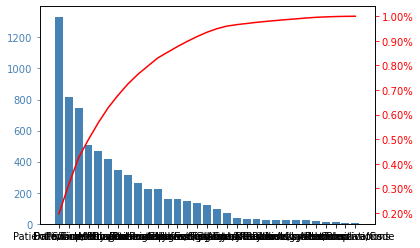

In [42]:
from matplotlib.ticker import PercentFormatter

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(section, cnt, color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(section, [i/sum(cnt) for i in cumsum], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

In [43]:
common_sections = section
len(common_sections)

31

### Manual inspection of heading extraction and normalization

### Visualization of negation status by section

...

In [44]:
all_annot = {}
for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "test"), file)
    reader.get_annotation()
    if not reader.ann:
        print(f'{file} does not contain assertion annotations')
        continue
    all_annot = {**all_annot, **reader.ann}

In [45]:
for f in all_annot:
    reader = Reader(os.path.join(DATA_DIR, "test"), f)
    reader.get_all_headings()
    h_left = [i[1] for i in reader.all_headings]
    for i in all_annot[f]:
        if i == 'length':
            continue
        annotation = all_annot[f][i]

        s_i = bisect.bisect_left(h_left, all_annot[f][i]['b']) - 1 
        if s_i == -1:
            section = 'other'
        else:
            section = [i[0] for i in reader.all_headings][s_i]
        all_annot[f][i]['s'] = section

### Statistics
- The number of extracted headings using pattern `(\n[a-zA-Z -]+)(( :\n)|( : ))`: 
- The number of unique headings (all in lower case and trimmed): 

- Map them to the ontology. 
    - The total number of headings after removing non-header phrases:
    - The number of unclassified headings:    
    - Note that all unclassified headings only have one occurrance. ??
    > The percentage of classified headings:
    
    - The number of unique headings: 
    - After normalization, the number of section types: 
    > The percentage of normalized section types: 
    
    
    
    
    
    
    

In [46]:
ori_headings = []
norm_headings = []
non_normalized = set()
non_norm_cnt = 0

for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "test"), file)
    matches = header_pattern(reader.txt)
    for m in matches:
        match = std_header(m.group(0))
        phrase0 = re.sub(" :$", "", m.group(0).strip().lower())
        if match:
            norm_headings.append(match)
            if match == '?' or match == 'Unknown/Unclassified':
                non_norm_cnt += 1
#                 if phrase0 in non_normalized:
#                     print(f'"{phrase0}" cannot be normalized. And it has occurred at least once.' )
                non_normalized.add(phrase0)
        ori_headings.append(phrase0)


In [47]:
unclassified_cnt = sum([i=='?' or i == 'Unknown/Unclassified' for i in norm_headings])

print(f"""
- The number of extracted headings using the pattern: {len(ori_headings)}
- The number of unique extractions (all in lower case and trimmed): {len(set(ori_headings))}

- Map them to the ontology. 
    - The total number of headings after removing non-header phrases: {len(norm_headings)}
    - The number of headings that cannot be normalized: {unclassified_cnt}   
    - Note that all such headings only have one occurrance. ?? (FALSE STATEMENT)
    --> The percentage of normalized headings: {int(100 - 100*unclassified_cnt/len(norm_headings))}%
    
    - After normalization, the number of section types: {len(set(norm_headings))}
    --> The percentage of normalized section types: ??

""")


- The number of extracted headings using the pattern: 8709
- The number of unique extractions (all in lower case and trimmed): 854

- Map them to the ontology. 
    - The total number of headings after removing non-header phrases: 8692
    - The number of headings that cannot be normalized: 1879   
    - Note that all such headings only have one occurrance. ?? (FALSE STATEMENT)
    --> The percentage of normalized headings: 78%
    
    - After normalization, the number of section types: 33
    --> The percentage of normalized section types: ??




## Concepts that have an assertion status

#### Percentage of the 6 assertion types  in each section 

In [48]:
df = pd.DataFrame(columns=['b', 'e', 't', 'a', 'c', 's'])
for f in all_annot:
    for i in all_annot[f]:
        if i == 'length':
            continue
        tmp =pd.DataFrame(all_annot[f][i], index=['::'.join([f, i])])
        df = pd.concat([df, tmp], ignore_index=False)

In [49]:
df.head(20)

,b,e,t,a,c,s
0359::T1,359,380,problem,present,diabetic ketoacidosis,Diagnoses
0359::T2,386,418,problem,present,non q wave myocardial infarction,Diagnoses
0359::T3,424,445,problem,present,renal artery stenosis,Diagnoses
0359::T5,474,494,problem,present,mitral regurgitation,Diagnoses
0359::T6,526,549,problem,present,coronary artery disease,Diagnoses
0359::T8,619,640,problem,present,myocardial infarction,Diagnoses
0359::T9,684,699,problem,present,diabetes type 2,Diagnoses
0359::T10,705,719,problem,present,cardiomyopathy,Diagnoses
0359::T11,725,749,problem,present,congestive heart failure,Diagnoses
0359::T12,755,767,problem,present,hypertension,Diagnoses


In [50]:
# save to csv 
# df.to_csv("explore_i2b2-2010-v3.0-concepts-test.csv", index_label="id")

In [51]:
print("Percentage of 'Problems' that do not have a valid section type:")
try: 
    print((df['s'].value_counts()['Unknown/Unclassified'] + df['s'].value_counts()['?'])/sum(df['s'].value_counts()))
except KeyError:
    print(df['s'].value_counts()['?']/sum(df['s'].value_counts()))

Percentage of 'Problems' that do not have a valid section type:
0.09876010781671159


In [52]:
df['s'].value_counts()

Hospital course                     4069
Present illness                     2545
?                                   1832
Subsection                          1637
Past history                        1298
Diagnoses                           1234
Physical examination/Status         1096
Date/Time                            850
Medications                          502
Laboratory tests                     484
Investigations/Results               459
Follow-up/Instructions               384
Assessment/Plan                      248
Assessment                           247
Problems                             238
other                                234
Providers                            184
Reasons/Indications                  172
Radiology                            125
Review of systems                    119
Allergies                            118
Family history                       114
Chief complaint                       93
Procedures/Surgery                    93
Addendum        

In [244]:
df = df[(df['s']!='?') & (df['s']!='Unknown/Unclassified')]
print('Invalid sections removed')

Invalid sections removed


In [245]:
plotdf = None
for i, sec in enumerate(df['s'].value_counts().index):
#     if i ==  15:
#         break
    s = df[df['s']==sec]['a'].value_counts()
    if plotdf is None:
        plotdf = s.rename(sec)
    else:
        plotdf = pd.concat([plotdf, s.rename(sec)], axis=1)


In [246]:
plotdf = plotdf.fillna(0)

In [253]:
# plotdf.to_csv('results.csv')

In [169]:
import plotly.graph_objects as go
import plotly.offline as phy

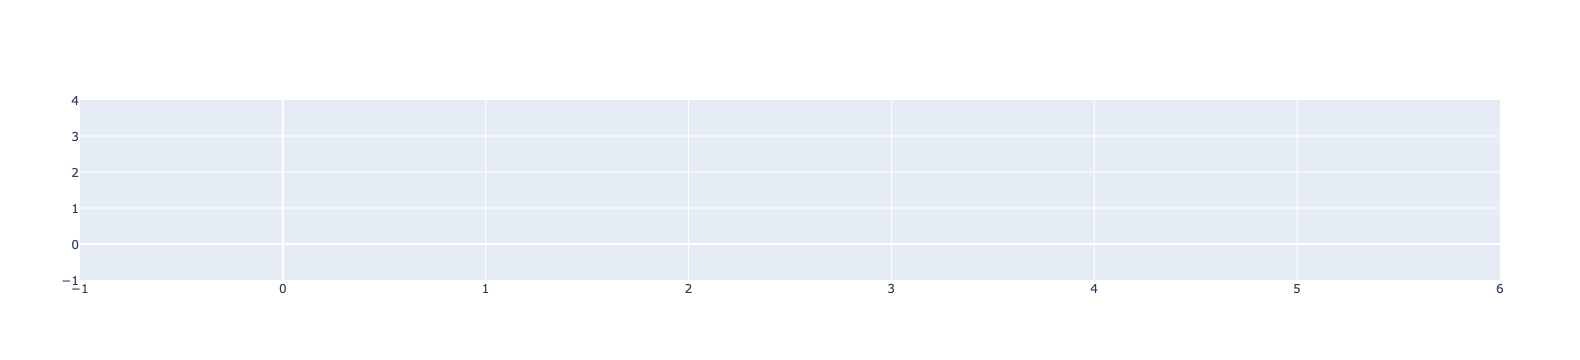

In [170]:
fig = go.Figure()
fig.update_polars(radialaxis=dict(range=[0, 1]))
# categories = ['present', 'absent', 'associated_with_someone_else', \
#               'hypothetical', 'possible', 'conditional']
# fig.add_trace(go.Scatterpolar(
#     r=[0]*5,
#     theta=categories, 
#     fill='toself', 
#     name=''
# ))

Hospital course (n=2486)


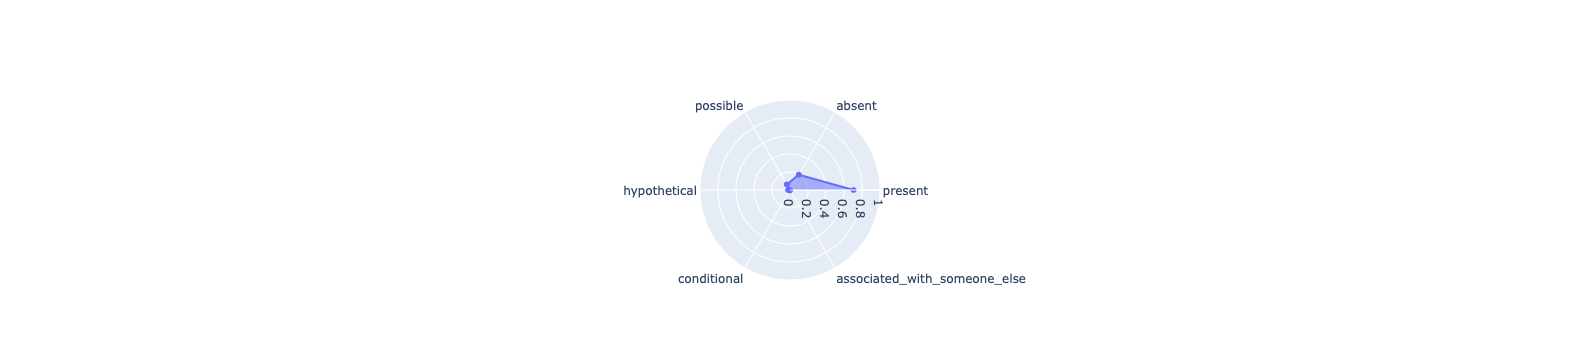

Present illness (n=1414)


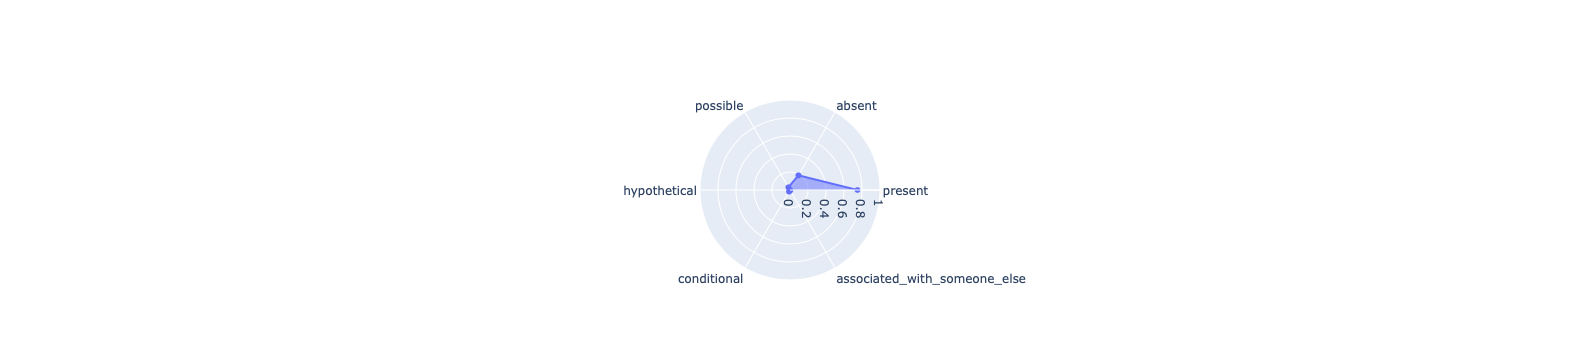

Diagnoses (n=989.0)


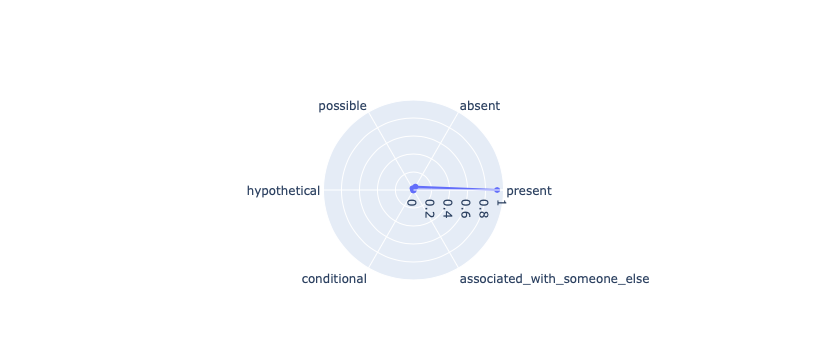

Subsection (n=952.0)


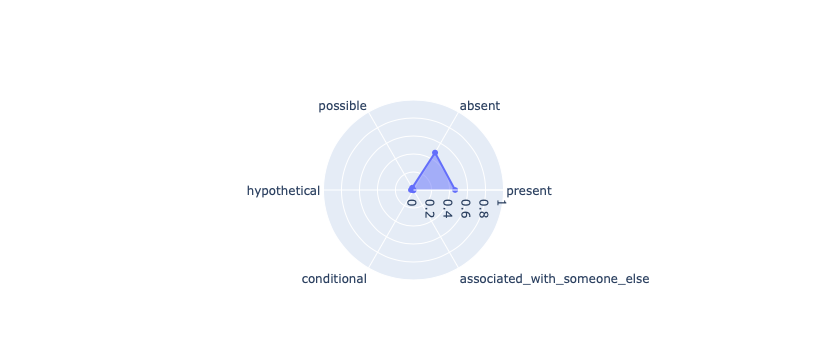

Past history (n=656.0)


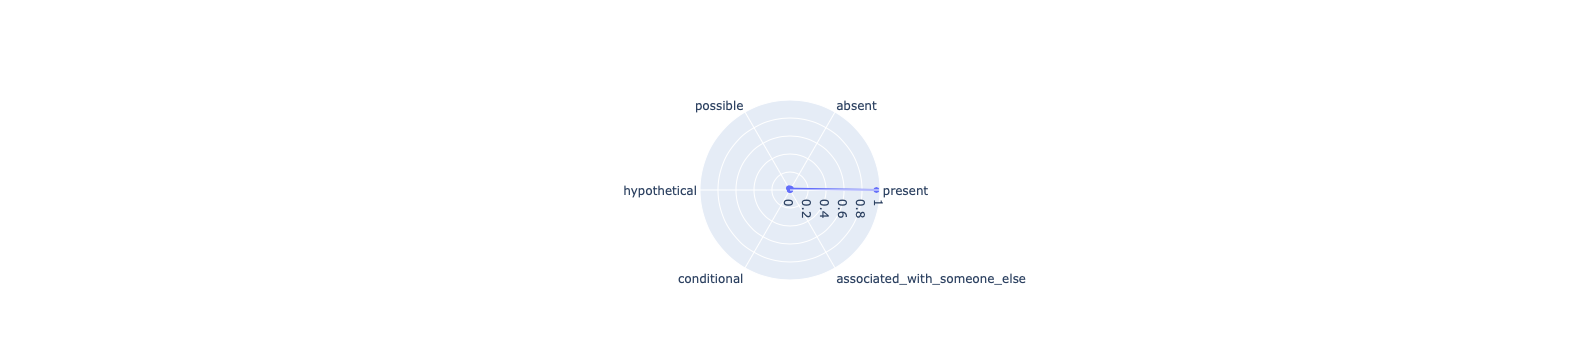

Physical examination/Status (n=636.0)


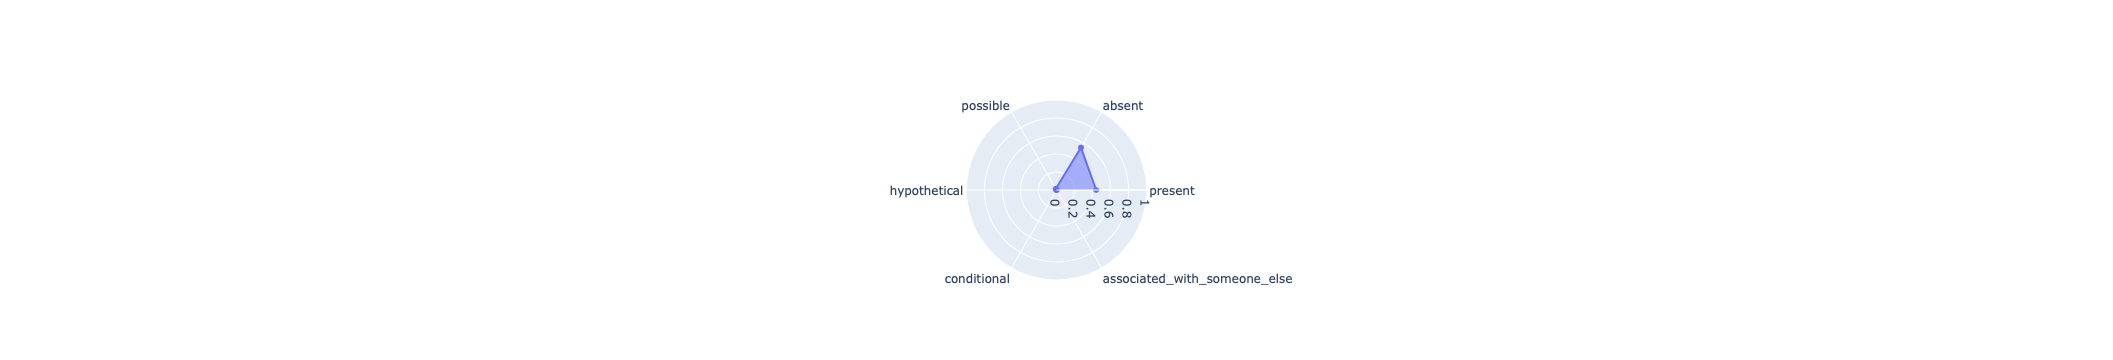

Follow-up/Instructions (n=450.0)


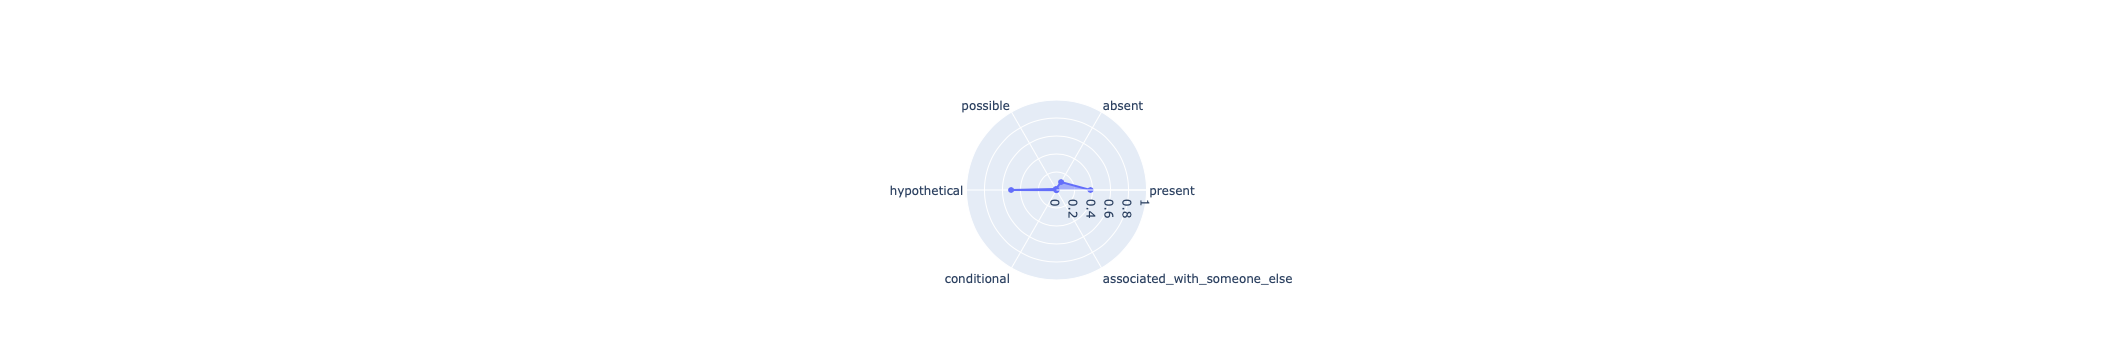

Date/Time (n=402.0)


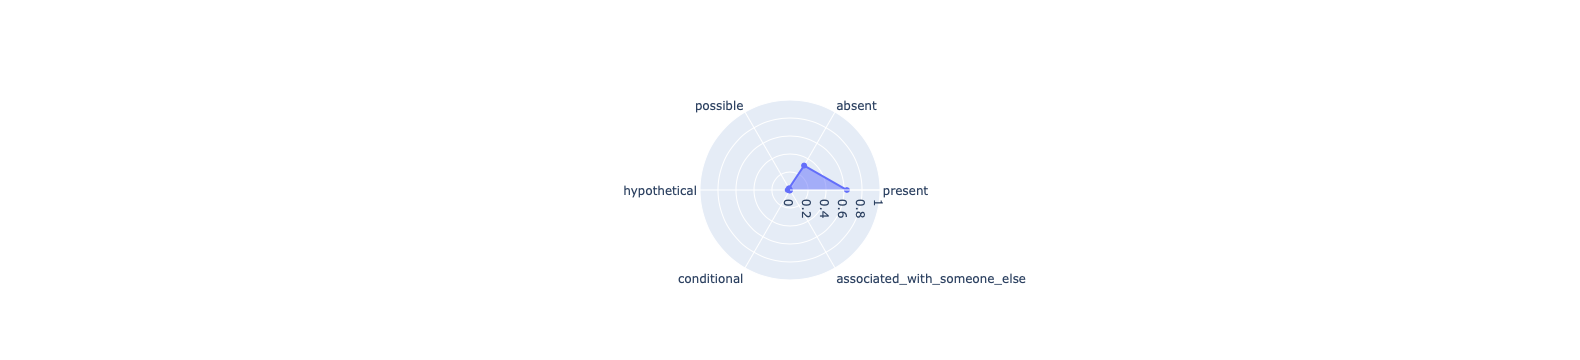

Medications (n=354.0)


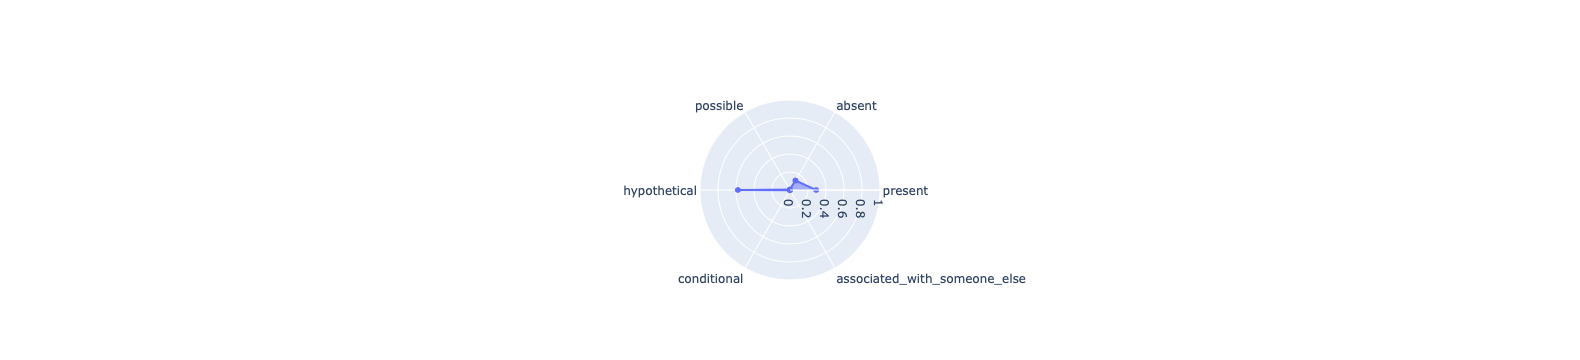

Investigations/Results (n=344.0)


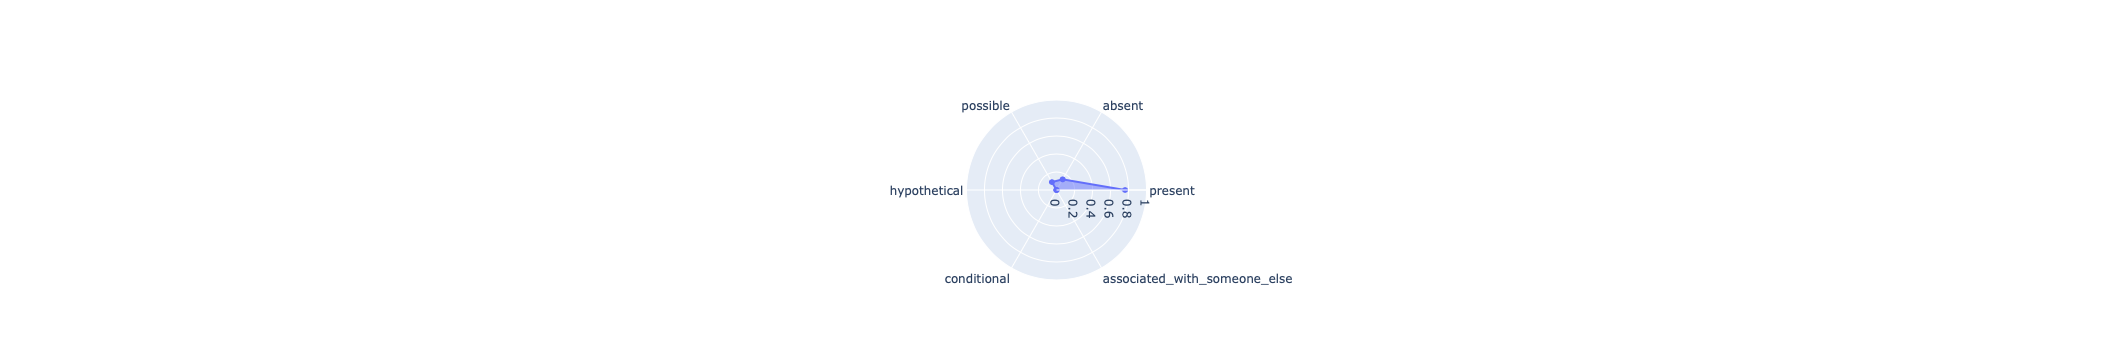

Laboratory tests (n=260.0)


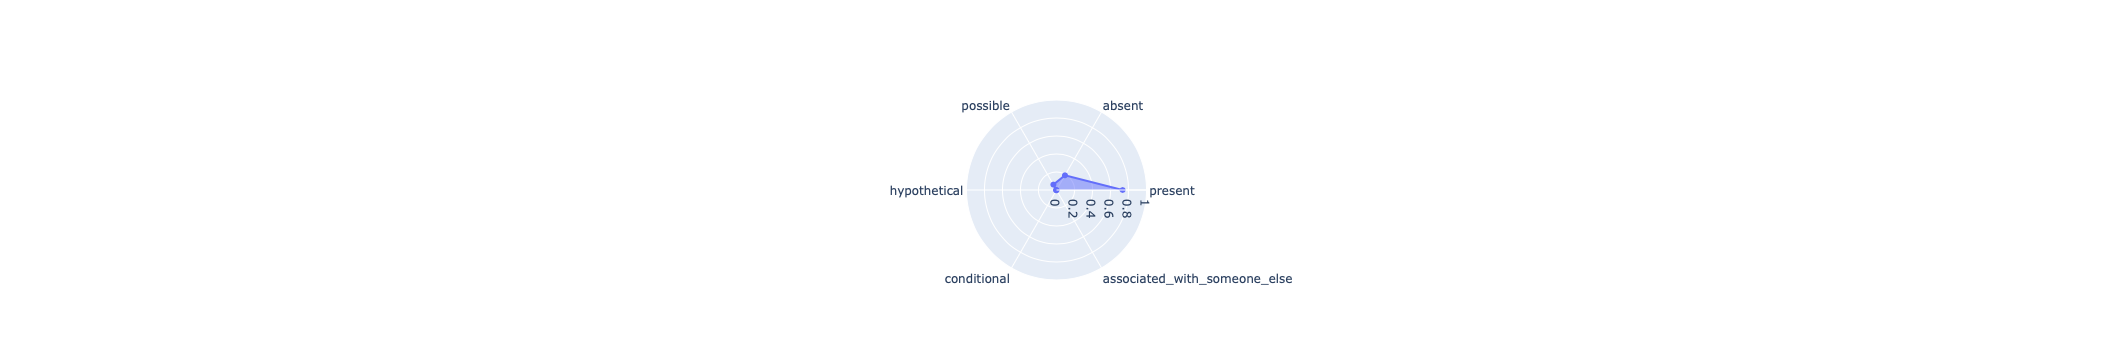

Assessment/Plan (n=252.0)


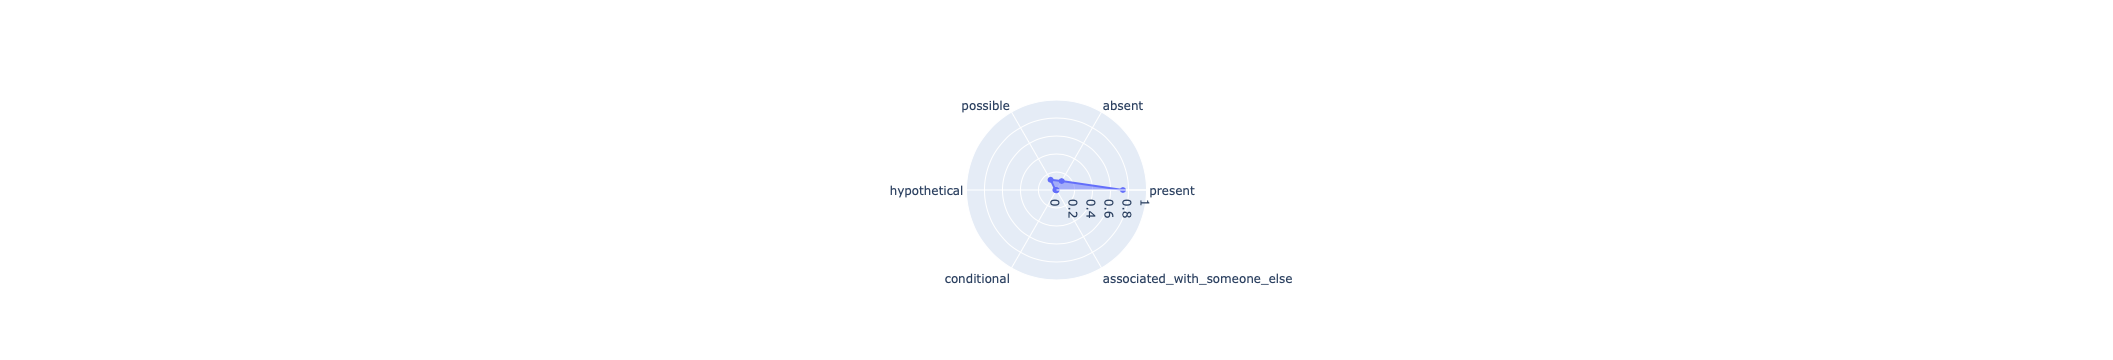

Problems (n=177.0)


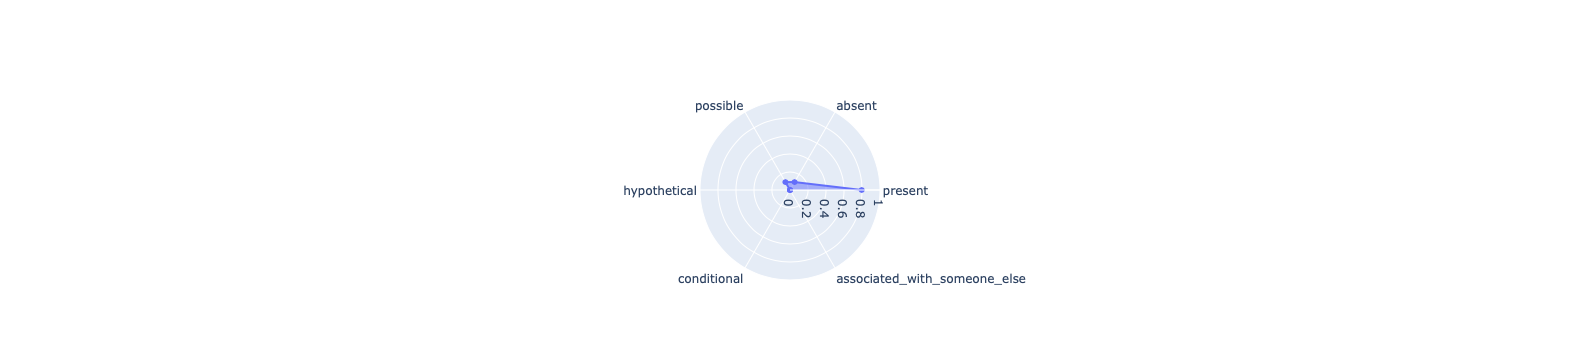

Assessment (n=166.0)


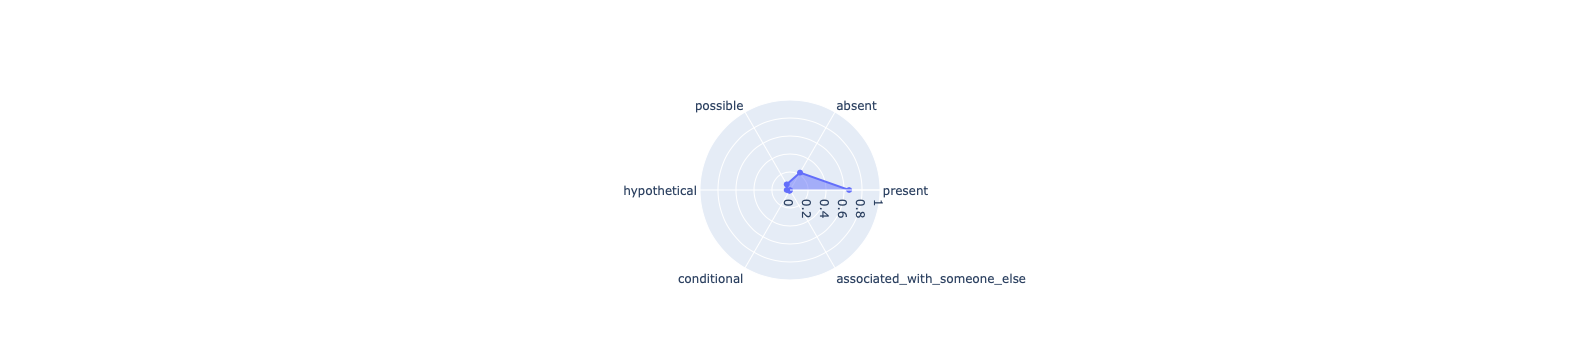

Allergies (n=160.0)


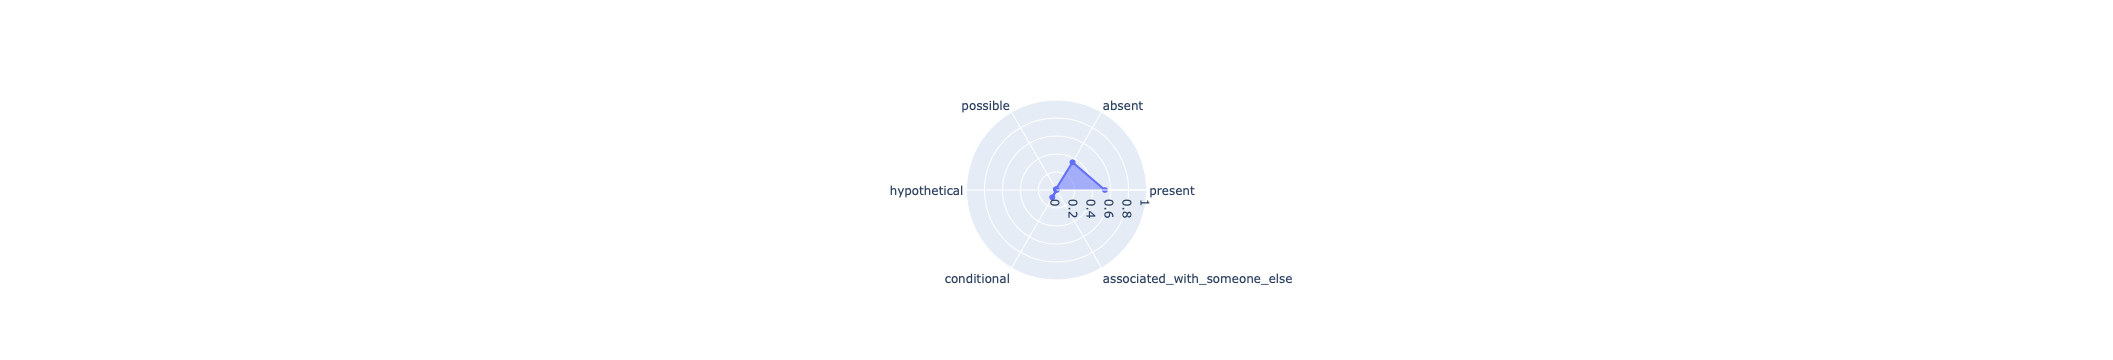

Procedures/Surgery (n=137.0)


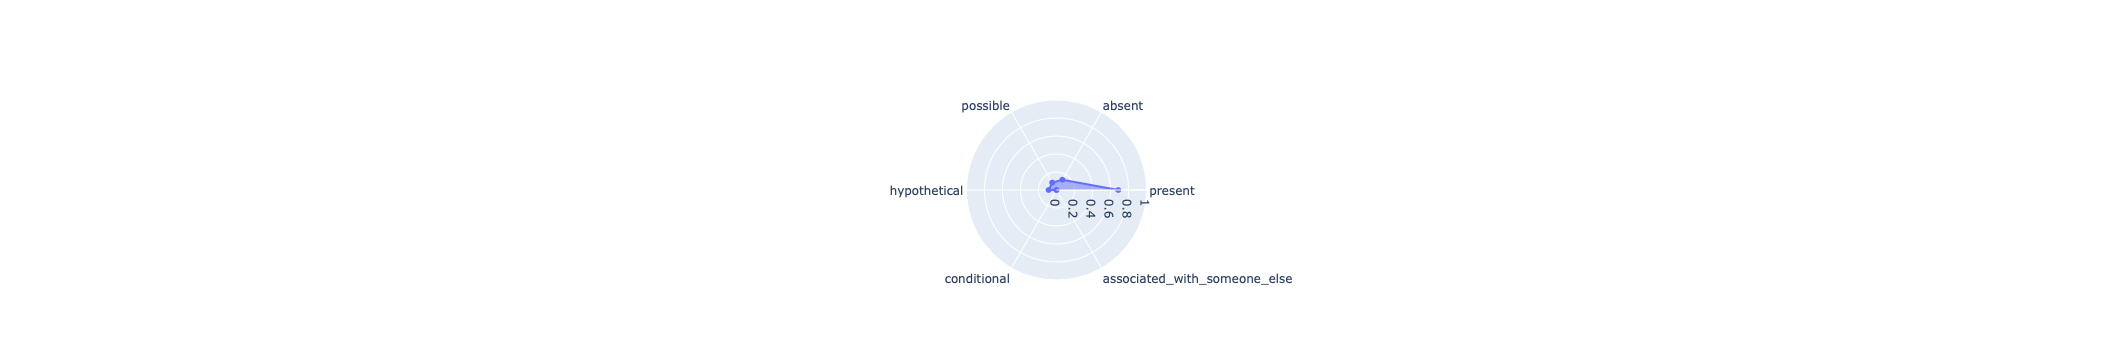

Chief complaint (n=116.0)


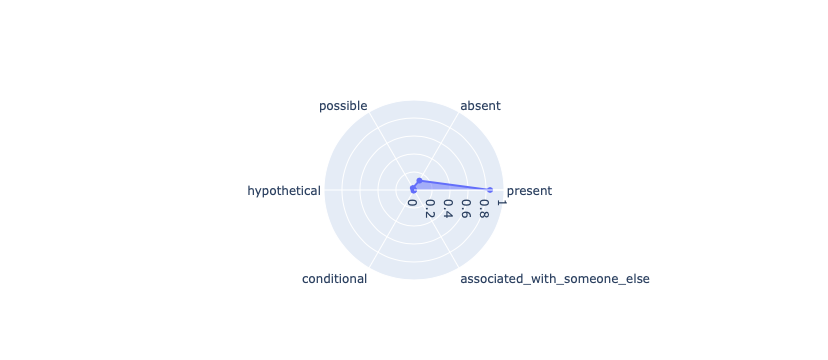

Providers (n=115.0)


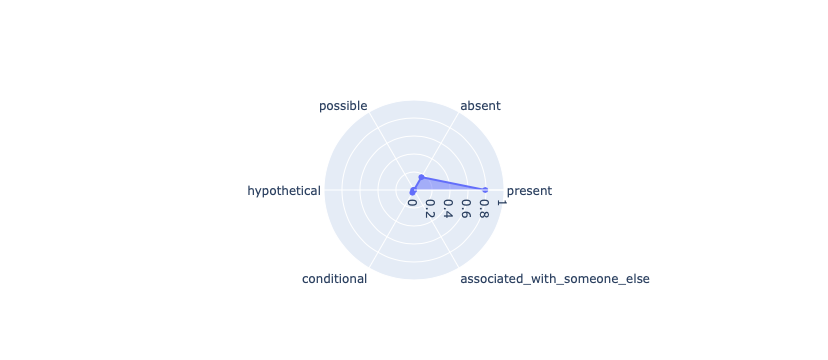

Reasons/Indications (n=109.0)


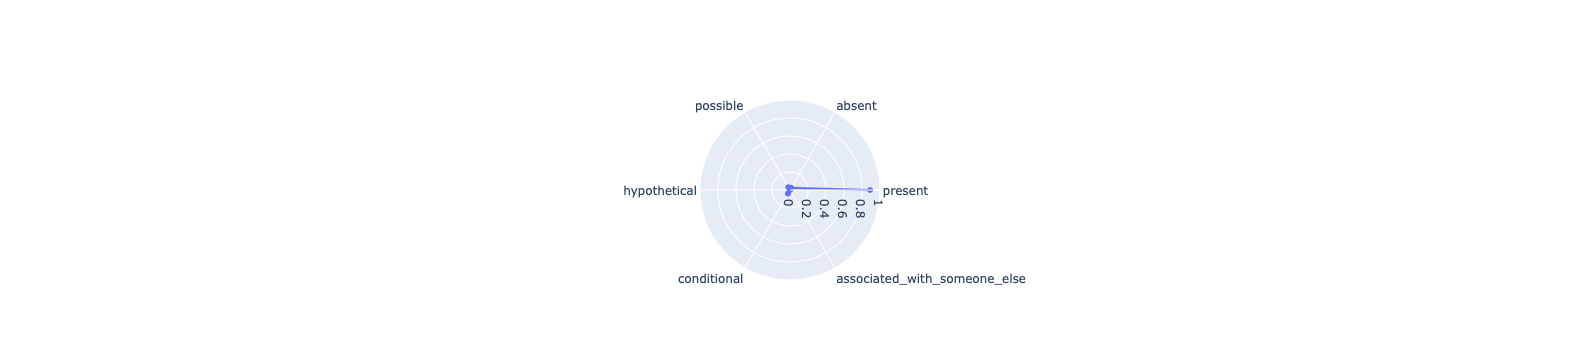

other (n=97.0)


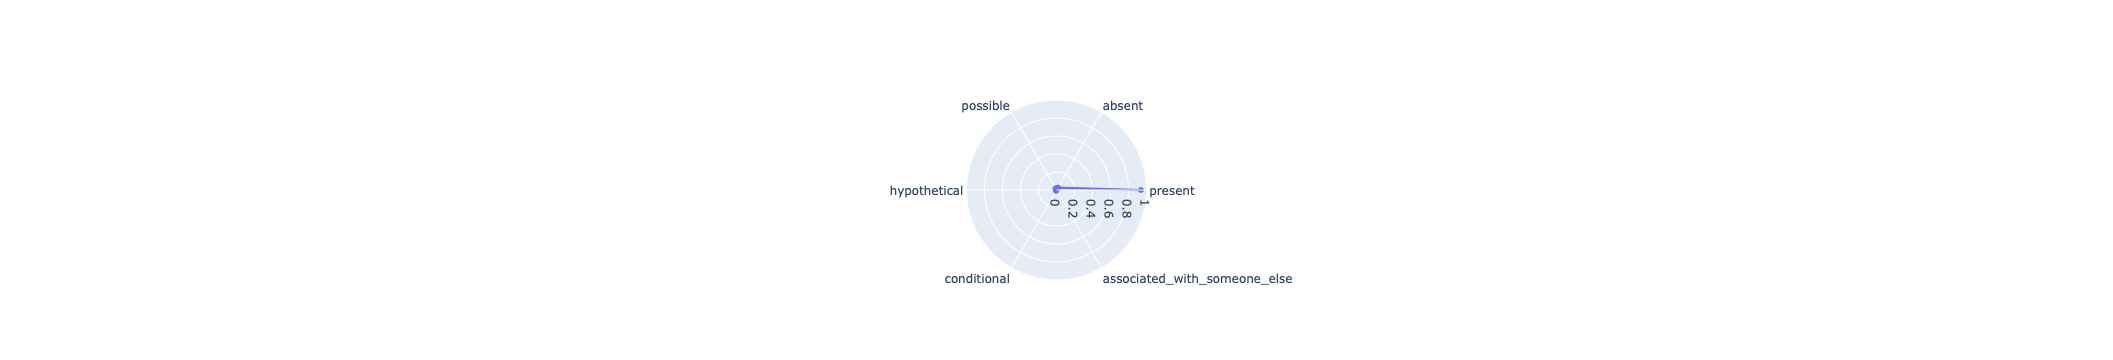

Review of systems (n=72.0)


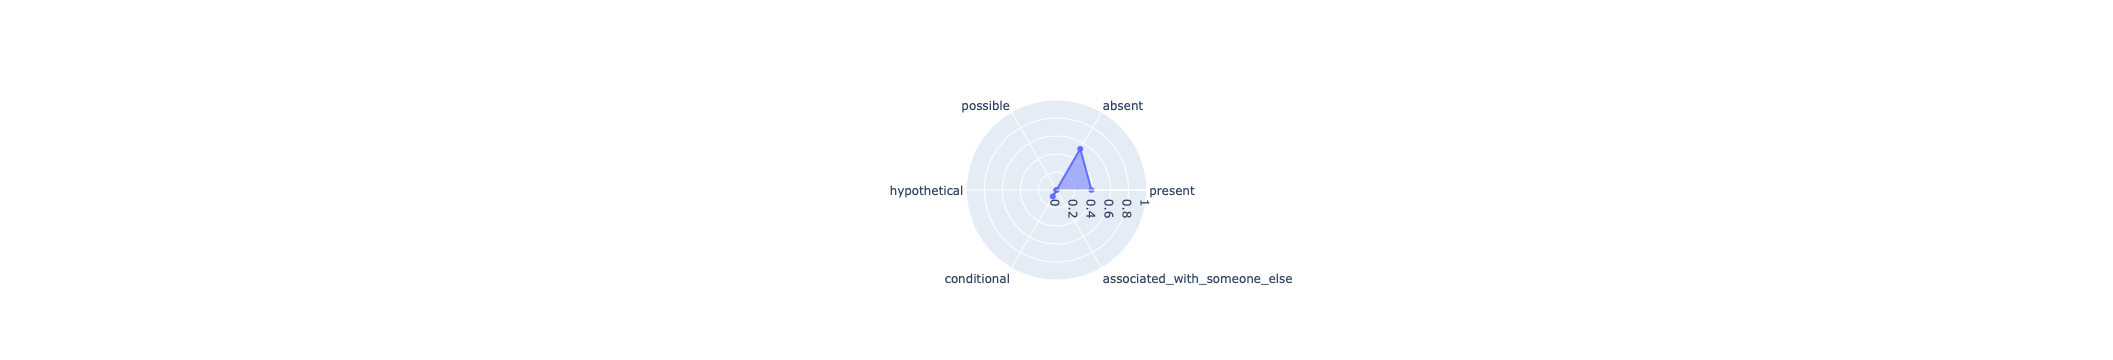

Family history (n=69.0)


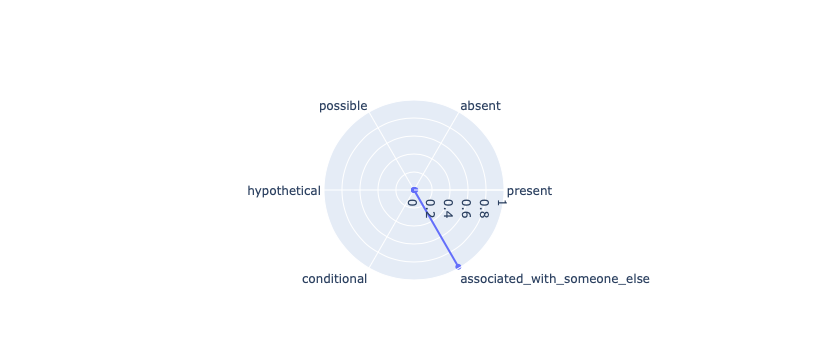

Radiology (n=56.0)


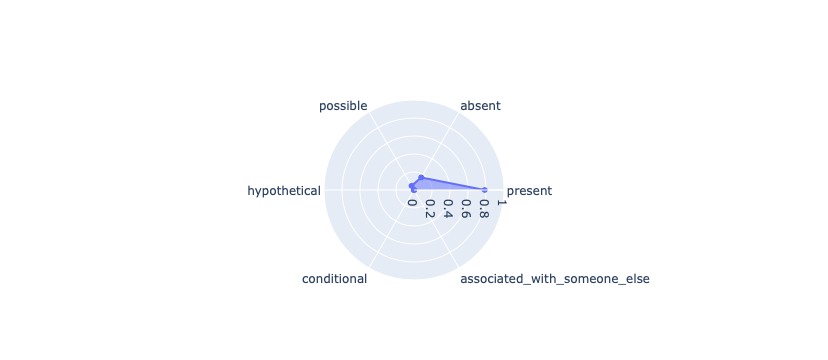

Nutrition (n=39.0)


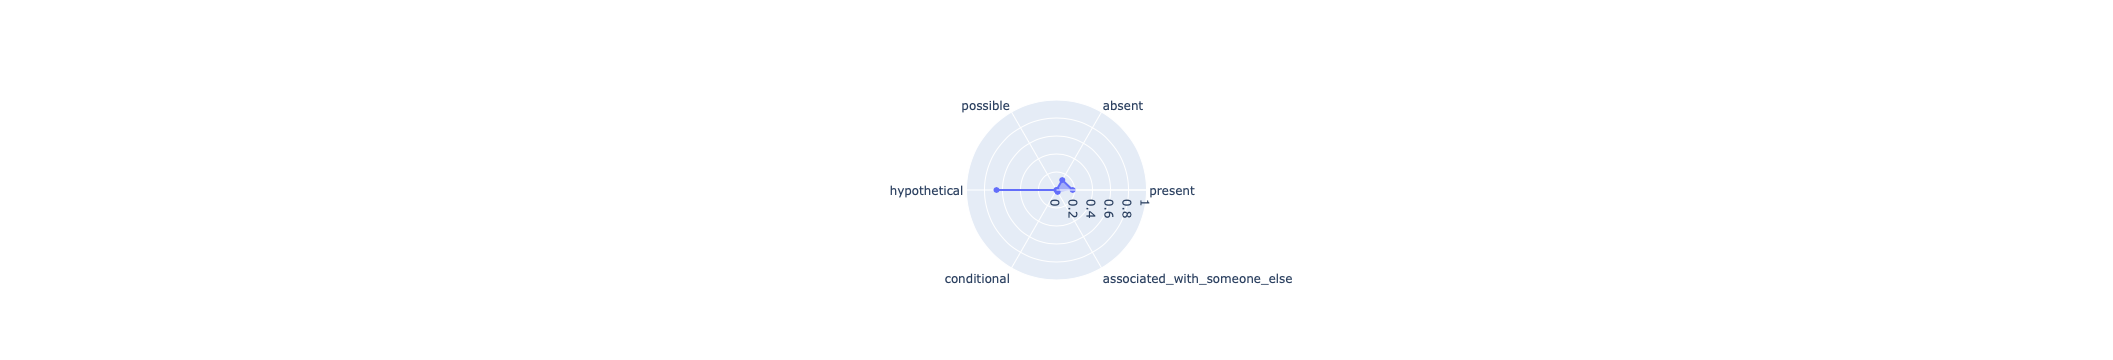

Consultations (n=28.0)


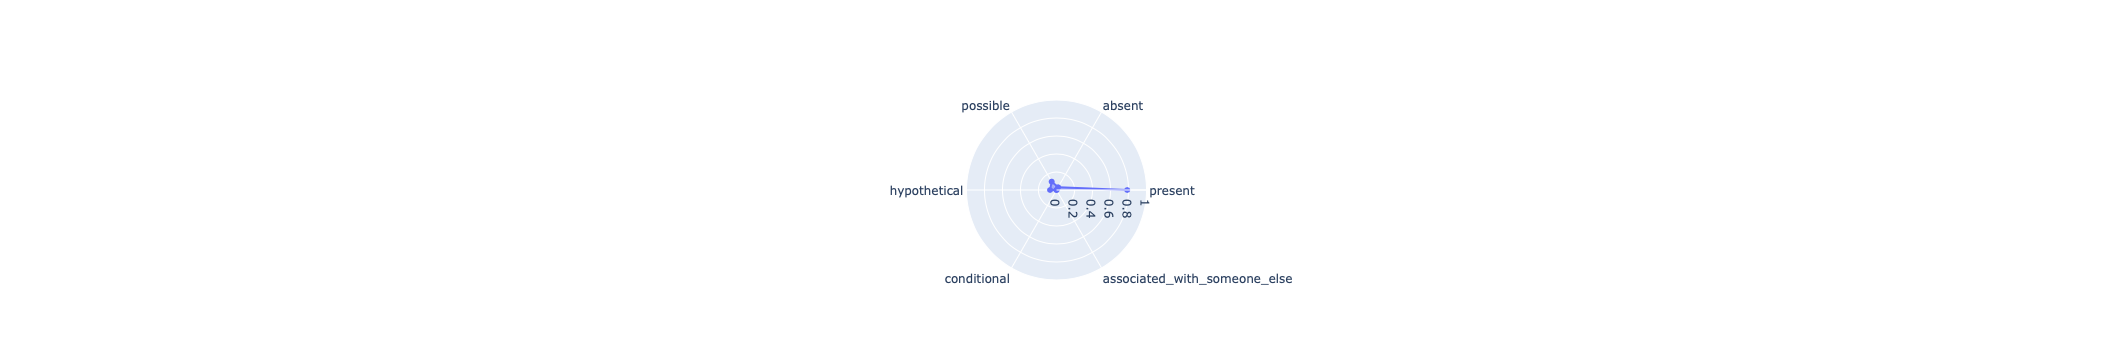

Social history (n=14.0)


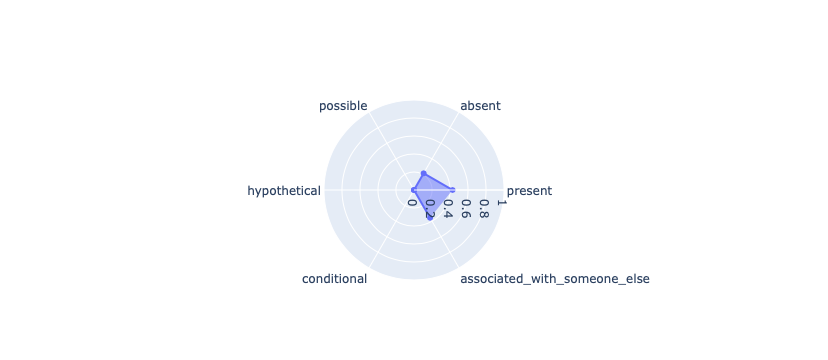

Addendum (n=11.0)


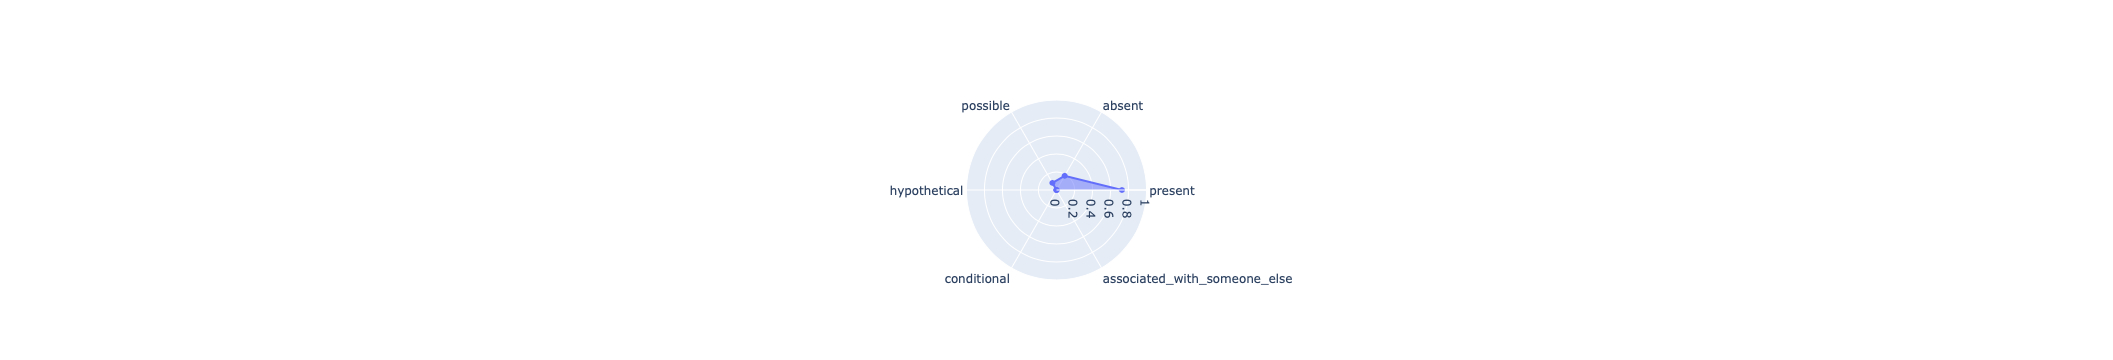

Immunizations (n=7.0)


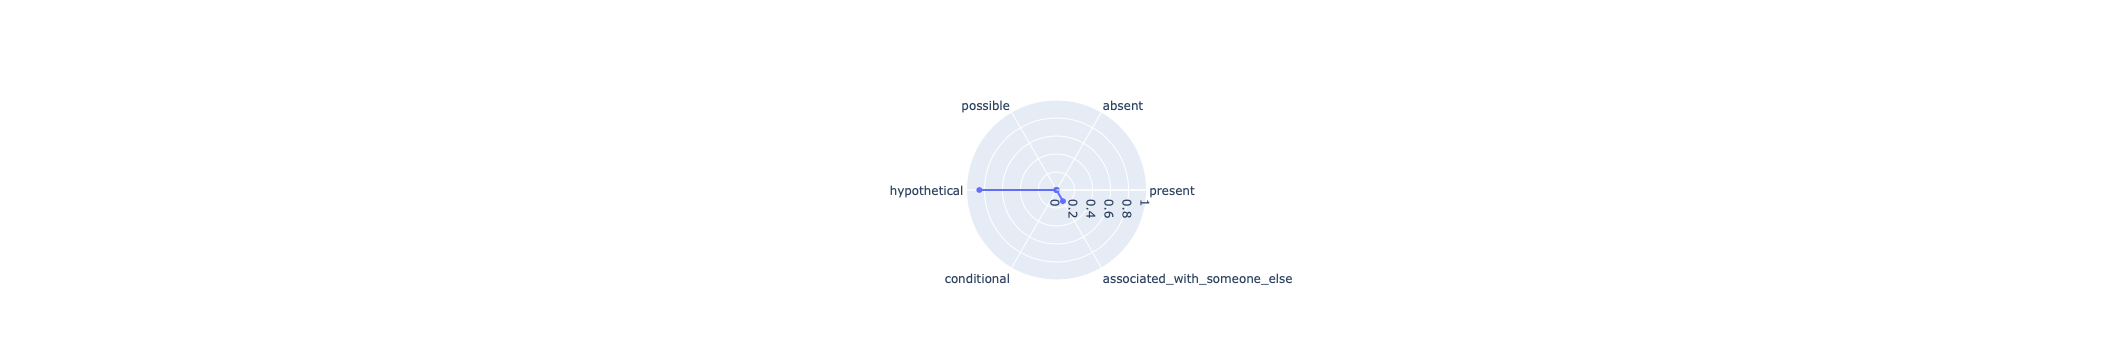

Patient information/Demographics (n=2.0)


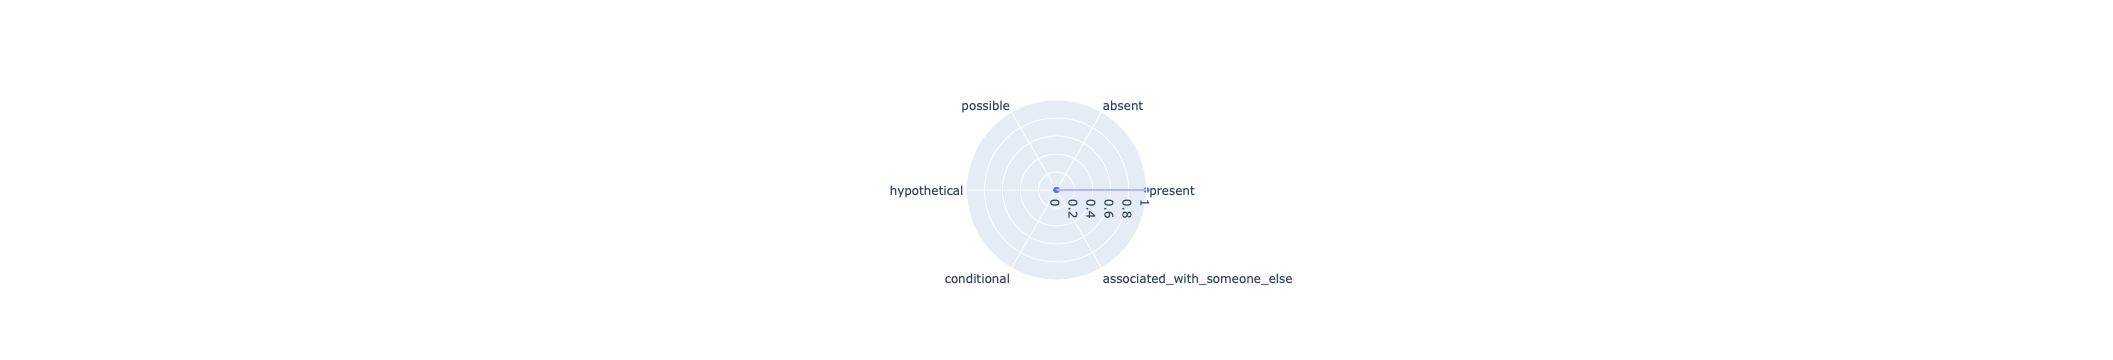

In [171]:
for i in plotdf:
    fig = go.Figure()
    fig.update_polars(radialaxis=dict(range=[0, 1]))
    fig.add_trace(go.Scatterpolar(
        r=plotdf[i]/plotdf[i].sum(),
        theta=plotdf.index, 
        fill='toself', 
        name=i
    ))
    print(f'{i} (n={plotdf[i].sum()})')
    fig.show()
# Conclusions:
    # Mostly present: Hospital course, present illness, 
    # present: Diagnoses

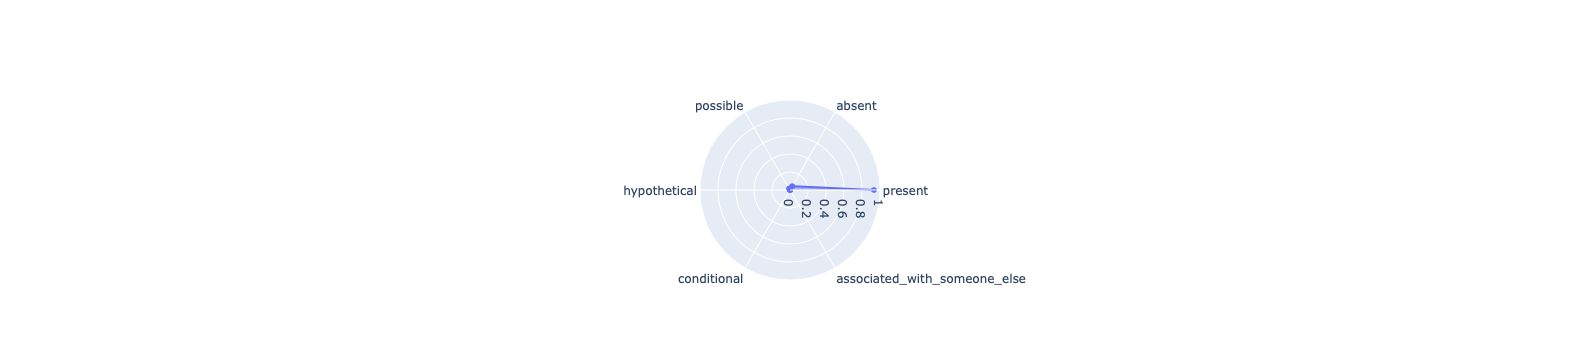

In [37]:
fig.show()

#### Distribution of Contextual Information - Location of Headings 
(Presented in the report of 20221205. Skipped here.)
Fist make sure only concepts whose type is "problem" have assertion info. 
Then show the disctribution of the 6 types of assertion.
Lastly, show the distribution of assertion by section type. Note that only a few section types are selected here. 

In [ ]:
# only concepts of "problem" have annotation of its assertion status
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length': 
            continue
        if annot[i]['t'] != 'problem':
            print(f'{f}: {annot[i]["c"]}')

In [ ]:
ast = []
loc = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        ast.append(annot[i]['a'])
        loc.append(annot[i]['b']/annot['length'])

In [ ]:
df = pd.DataFrame({'ast': ast, 'loc': loc})

In [ ]:
# distribution of negations
import seaborn as sns
sns.displot(df, x='loc', binwidth=.01, col='ast')

In [ ]:
sections = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        sections.append(annot[i]['s'])

In [ ]:
df['sections'] = sections

In [ ]:
df[:3]

In [ ]:
for s in common_sections:
    if s not in df.sections.values:
        continue
    sns.displot(df.loc[df['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()

In [ ]:
for s in common_sections:
    tmp = df.loc[(df['sections']==s) & (df['ast']!= 'present')]
    if len(tmp) < 10:
        continue
    sns.displot(tmp.loc[tmp['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()

In [ ]:
# hexagon 

## All concepts, including concepts that do not have an assertion status

### Save annotations to a csv file

...

In [58]:
all_annot = {}
for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "test"), file)
    reader.get_annotation(must_have_assertion=False)
    if not reader.ann:
        print(f'{file} does not contain assertion annotations')
        continue
    all_annot = {**all_annot, **reader.ann}

In [59]:
for f in all_annot:
    reader = Reader(os.path.join(DATA_DIR, "test"), f)
    reader.get_all_headings()
    h_left = [i[1] for i in reader.all_headings]
    for i in all_annot[f]:
        if i == 'length':
            continue
        annotation = all_annot[f][i]

        s_i = bisect.bisect_left(h_left, all_annot[f][i]['b']) - 1 
        if s_i == -1:
            section = 'other'
        else:
            section = [i[0] for i in reader.all_headings][s_i]
        all_annot[f][i]['s'] = section

#### Percentage of the 6 assertion types  in each section 

In [71]:
df = pd.DataFrame(columns=['b', 'e', 't', 'a', 'c', 's'])
for num, f in enumerate(all_annot):
    print(f'{num}, {f}')
    for i in all_annot[f]:
        if i == 'length':
            continue
        tmp =pd.DataFrame(all_annot[f][i], index=['::'.join([f, i])])
        df = pd.concat([df, tmp], ignore_index=False)

0, 0359
1, 0371
2, 0417
3, 0403
4, 0365
5, 0173
6, 0167
7, 0198
8, 0007
9, 0013
10, 0239
11, 0205
12, 0211
13, 0210
14, 0204
15, 0238
16, 0012
17, 0006
18, 0199
19, 0166
20, 0172
21, 0402
22, 0364
23, 0370
24, 0416
25, 0358
26, 0428
27, 0366
28, 0400
29, 0414
30, 0372
31, 0399
32, 0158
33, 0164
34, 0170
35, 0038
36, 0010
37, 0004
38, 0212
39, 0206
40, 0207
41, 0213
42, 0005
43, 0011
44, 0039
45, 0171
46, 0165
47, 0159
48, 0398
49, 0415
50, 0373
51, 0367
52, 0401
53, 0429
54, 0405
55, 0363
56, 0377
57, 0411
58, 0439
59, 0388
60, 0161
61, 0175
62, 0149
63, 0015
64, 0001
65, 0029
66, 0217
67, 0203
68, 0202
69, 0216
70, 0028
71, 0014
72, 0148
73, 0174
74, 0160
75, 0389
76, 0438
77, 0376
78, 0410
79, 0404
80, 0362
81, 0412
82, 0374
83, 0360
84, 0406
85, 0348
86, 0176
87, 0162
88, 0189
89, 0002
90, 0016
91, 0200
92, 0214
93, 0228
94, 0229
95, 0215
96, 0201
97, 0017
98, 0003
99, 0188
100, 0163
101, 0177
102, 0349
103, 0361
104, 0407
105, 0413
106, 0375
107, 0448
108, 0474
109, 0312
110, 0306


In [72]:
df.head(20)

,b,e,t,a,c,s
0359::T1,359,380,problem,present,diabetic ketoacidosis,Diagnoses
0359::T2,386,418,problem,present,non q wave myocardial infarction,Diagnoses
0359::T3,424,445,problem,present,renal artery stenosis,Diagnoses
0359::T4,460,468,treatment,None,stenting,Diagnoses
0359::T5,474,494,problem,present,mitral regurgitation,Diagnoses
0359::T6,526,549,problem,present,coronary artery disease,Diagnoses
0359::T7,564,592,treatment,None,coronary artery bypass graft,Diagnoses
0359::T8,619,640,problem,present,myocardial infarction,Diagnoses
0359::T9,684,699,problem,present,diabetes type 2,Diagnoses
0359::T10,705,719,problem,present,cardiomyopathy,Diagnoses


In [74]:
# save to csv 
df.to_csv("explore_i2b2-2010-v3.0-ALL_concepts-test.csv", index_label="id")

In [73]:
print("Percentage of concepts that do not have a valid section type:")
try: 
    print((df['s'].value_counts()['Unknown/Unclassified'] + df['s'].value_counts()['?'])/sum(df['s'].value_counts()))
except KeyError:
    print(df['s'].value_counts()['?']/sum(df['s'].value_counts()))

Percentage of concepts that do not have a valid section type:
0.10404585749516763


In [52]:
df['s'].value_counts()

Hospital course                     4069
Present illness                     2545
?                                   1832
Subsection                          1637
Past history                        1298
Diagnoses                           1234
Physical examination/Status         1096
Date/Time                            850
Medications                          502
Laboratory tests                     484
Investigations/Results               459
Follow-up/Instructions               384
Assessment/Plan                      248
Assessment                           247
Problems                             238
other                                234
Providers                            184
Reasons/Indications                  172
Radiology                            125
Review of systems                    119
Allergies                            118
Family history                       114
Chief complaint                       93
Procedures/Surgery                    93
Addendum        